In [2]:
%pip install pillow
%pip install numpy

Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 72.9 MB/s  0:00:00 79.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [7]:
from IPython.display import display

# First step - Single image

In [ ]:
from PIL import Image,ImageDraw;

# The core structure
img = Image.new("RGB",(128,128),color= "white")

In [5]:
# Object that can be printed out
draw = ImageDraw.Draw(img)


draw.circle((64,64),radius=30,fill="black")

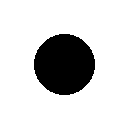

In [8]:
display(img)

# Second step - Make a bunch of random image

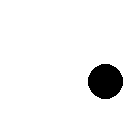

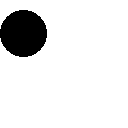

[None, None]

In [ ]:
import random

l = []
for i in range(5000):
    img = Image.new("RGB",(128,128),"white")
    draw = ImageDraw.Draw(img)
    # Stay in side
    radius = random.randint(10,40)
    # For now we ensure the shape is inside the canva
    center = (random.randint(radius,128-radius),random.randint(radius,128-radius))
    draw.circle(xy=center,radius=radius,fill="black")
    l.append(img)
    img.save(f"data/train/circles/{i}.png")

[display(img) for img in l[50:52]]


In [43]:
l = []
for i in range(5000):
    img = Image.new("RGB",(128,128),"white")
    draw = ImageDraw.Draw(img)
    points = [
    (random.randint(10, 118), random.randint(10, 118)),
    (random.randint(10, 118), random.randint(10, 118)),
    (random.randint(10, 118), random.randint(10, 118)),
]
    draw.polygon(points,fill="black")
    l.append(img)
    img.save(f"data/train/triangles/{i}.png")